In [2]:
using Random
using Distributions
using LinearAlgebra
using ForwardDiff
include("../Inversion/Plot.jl")
include("../Inversion/NGD.jl")
include("../Inversion/IPS.jl")
include("../Inversion/Utility.jl")

cos_error_estimation_particle (generic function with 3 methods)

In [3]:
mutable struct Setup_Param{IT<:Int}
    θ_names::Array{String,1}
    N_θ::IT
    N_y::IT
end

function Setup_Param(N_θ::IT, N_y::IT) where {IT<:Int}
    return Setup_Param(["θ"], N_θ, N_y)
end

Setup_Param

In [ ]:
function Gaussian_density_helper(θ_mean::Array{FT,1}, θθ_cov::Array{FT,2}, θ::Array{FT,1}) where {FT<:AbstractFloat}
    N_θ = size(θ_mean,1)
    
    return exp( -1/2*((θ - θ_mean)'* (θθ_cov\(θ - θ_mean)) )) / ( sqrt(det(θθ_cov)) )

end


function Gaussian_density(θ_mean::Array{FT,1}, θθ_cov::Array{FT,2}, θ::Array{FT,1}) where {FT<:AbstractFloat}
    N_θ = size(θ_mean,1)
    
    return exp( -1/2*((θ - θ_mean)'* (θθ_cov\(θ - θ_mean)) )) / ( (2π)^(N_θ/2)*sqrt(det(θθ_cov)) )

end

function Gaussian_2d(θ_mean::Array{FT,1}, θθ_cov::Array{FT,2}; std=2,  N_p = 100) where {FT<:AbstractFloat}
    
    N_p = 100
    std = 2
    U, S, _ = svd(θθ_cov)
    xy_p  = [cos.(LinRange(0, 2*pi, N_p))  sin.(LinRange(0, 2*pi, N_p))]'

    xy_p = U * (std * sqrt.(S) .* xy_p) + θ_mean*ones(N_p)'

    return xy_p[1, :], xy_p[2, :]
end


function log_concave(θ,  ϵ)
    θ₁, θ₂ = θ
    return -( (sqrt(ϵ)*θ₁ - θ₂)^2 + θ₂^4)/20
end


function compute_Eref(ϵ, ω, b)
    # analytical solution
    yy = Array(LinRange(-200.0, 200.0, 10^7))

    E1 = sum(exp.(-yy.^4/20))
    Eθ₁²  = sum((yy.^2 .+ 10).* exp.(-yy.^4/20))/ϵ  / E1
    Eθ₁θ₂ = sum(yy.^2 .* exp.(-yy.^4/20))/sqrt(ϵ)   /E1
    Eθ₂²  = sum(yy.^2 .* exp.(-yy.^4/20))     /E1
    Ecos = zeros(length(b))
    for i = 1:length(b)
        Ecos[i]  = sum(cos.((ω[i,1]/sqrt(ϵ) + ω[i,2])*yy .+ b[i]).* exp.(-yy.^4/20))/exp(5/ϵ*ω[i,1]^2) /E1
    end
    return [0;0], [Eθ₁² Eθ₁θ₂; Eθ₁θ₂ Eθ₂²], Ecos 
end

# Prior
m_0 = [1.0; 1.0]
C_0 = [4.0  0.0; 0.0  4.0]

compute_Eref (generic function with 1 method)

# Convex function

[ Info: ("finish ", "Fisher-Rao")
[ Info: ("finish ", "Gradient_descent")
[ Info: ("finish ", "Wasserstein")
[ Info: ("finish ", "Fisher-Rao")
[ Info: ("finish ", "Gradient_descent")
[ Info: ("finish ", "Wasserstein")
[ Info: ("finish ", "Fisher-Rao")
[ Info: ("finish ", "Gradient_descent")
[ Info: ("finish ", "Wasserstein")


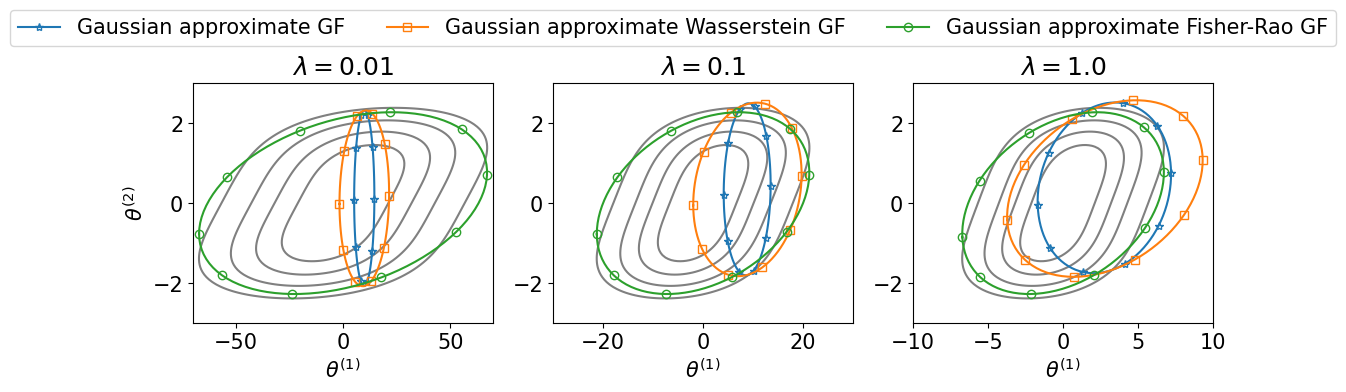

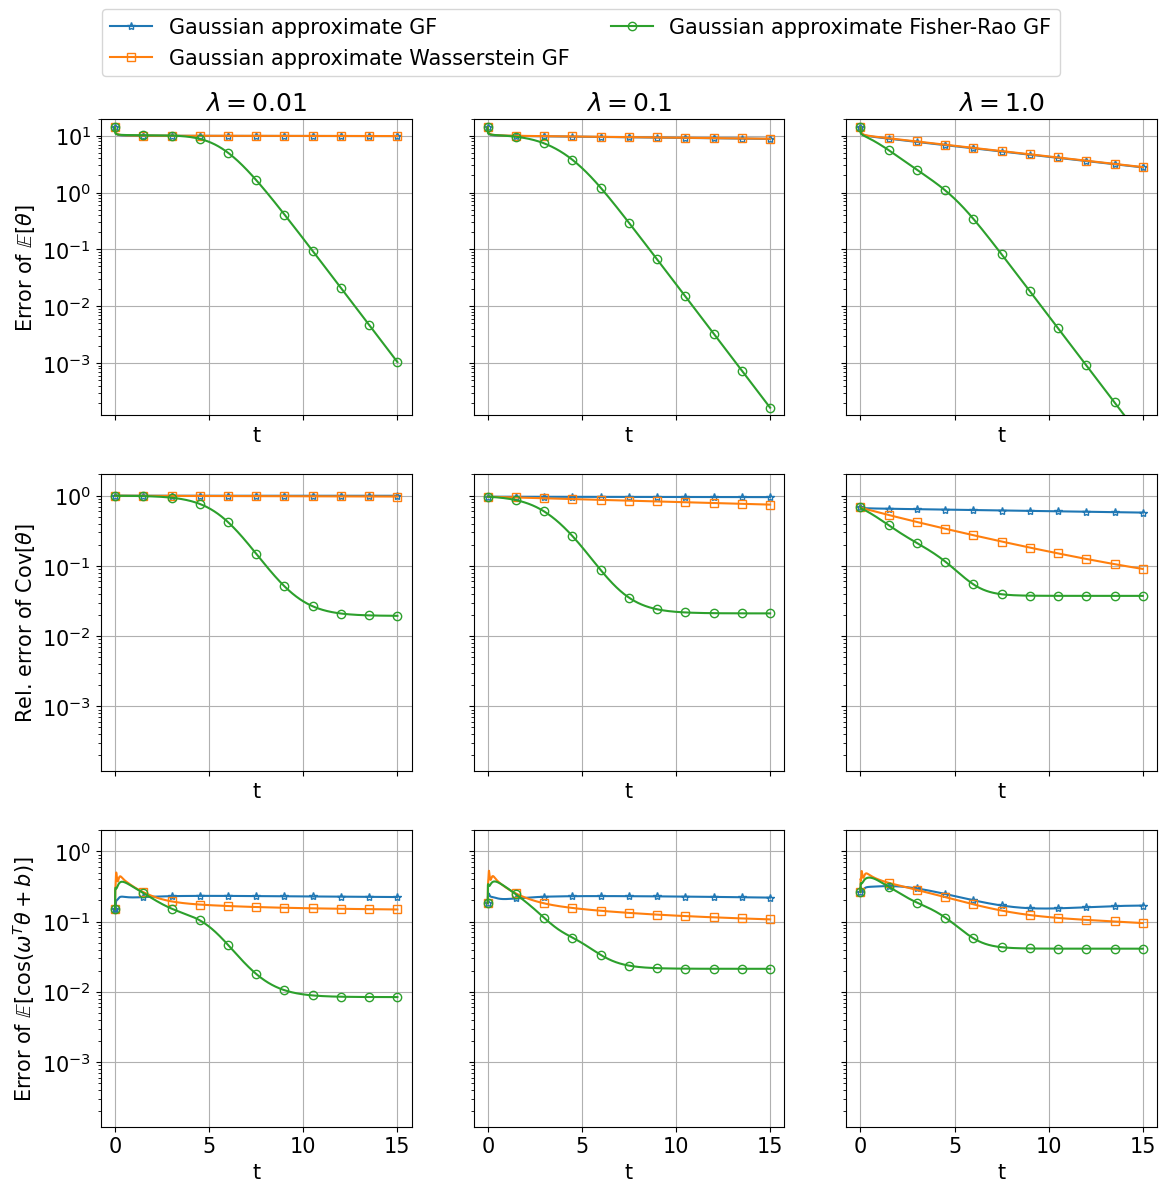

In [ ]:
Random.seed!(42)

ϵs = [0.01, 0.1, 1] 
fig_contour, ax_contour = PyPlot.subplots(ncols=length(ϵs), sharex=false, sharey=false, figsize=(12,4))
fig, ax = PyPlot.subplots(ncols=3, nrows=3, sharex=true, sharey="row", figsize=(12,12))



x_ranges = [[-70,70],[-30,30],[-10, 10],[-5, 5],[-3, 3]]

ω =  rand(Normal(0, 1), (20, 2))
b = rand(Uniform(0, 2*pi), 20)
for test_id = 1:length(ϵs)

    logρ(θ) = log_concave(θ,  ϵs[test_id])

    function compute_Φ(s_param, θ) 
        Φ =   -logρ(θ)
        dΦ =  -ForwardDiff.gradient(logρ, θ)
        ddΦ = -ForwardDiff.hessian(logρ, θ)
        return Φ, dΦ, ddΦ
    end


    # compute posterior distribution by MCMC
    x_min, x_max = x_ranges[test_id]
    y_min, y_max = -3, 3
    N_x, N_y = 200, 200
    xx = Array(LinRange(x_min, x_max, N_x))
    yy = Array(LinRange(y_min, y_max, N_y))
    X,Y = repeat(xx, 1, N_y), repeat(yy, 1, N_x)'
    Z = zeros(N_x, N_y)
    for i = 1:N_x
        for j = 1:N_y
            Z[i, j] = logρ( [X[i,j], Y[i,j]] )
        end
    end
    Z .= exp.(Z)
    ax_contour[test_id].contour(X, Y, Z, 5, colors="grey")
            
            
    N_θ = 2
    s_param = Setup_Param(N_θ, N_θ)
    Φ_func(s_param, θ) = compute_Φ(s_param, θ) 
    sampling_method = "UnscentedTransform"
    N_ens = 5
    Δt = 0.005 
    N_t_tot = 6000 #30000
    
    
    compute_gradient = "second-order"
    gradient_flow = "Fisher-Rao"
    ngd_obj = NGD_Run(s_param, Φ_func, m_0, C_0, sampling_method, N_ens,  Δt, N_t_tot, compute_gradient, gradient_flow);
    @info "finish ", gradient_flow
    
    gradient_flow = "Gradient_descent"
    gd_obj = NGD_Run(s_param, Φ_func, m_0, C_0, sampling_method, N_ens,  Δt, N_t_tot, compute_gradient, gradient_flow);
    @info "finish ", gradient_flow
    
    gradient_flow = "Wasserstein"
    wgd_obj = NGD_Run(s_param, Φ_func, m_0, C_0, sampling_method, N_ens,  Δt, N_t_tot, compute_gradient, gradient_flow);
    @info "finish ", gradient_flow
    
    N_t = div(N_t_tot, 2)
    N_p = 100
    X_gd,Y_gd = Gaussian_2d(gd_obj.θ_mean[N_t], gd_obj.θθ_cov[N_t]; std = 3, N_p=N_p)
    ax_contour[test_id].plot(X_gd, Y_gd, "-*", fillstyle="none", markevery=div(N_p, 10), color="C0", label="Gaussian approximate GF")
    X_wgd,Y_wgd = Gaussian_2d(wgd_obj.θ_mean[N_t], wgd_obj.θθ_cov[N_t])
    ax_contour[test_id].plot(X_wgd, Y_wgd, "-s", fillstyle="none", markevery=div(N_p, 10), color="C1", label="Gaussian approximate Wasserstein GF")
    X_ngd,Y_ngd = Gaussian_2d(ngd_obj.θ_mean[N_t], ngd_obj.θθ_cov[N_t])
    ax_contour[test_id].plot(X_ngd, Y_ngd, "-o", fillstyle="none", markevery=div(N_p, 10), color="C2", label="Gaussian approximate Fisher-Rao GF")
    ax_contour[test_id].set_title(L"\lambda = " * string(ϵs[test_id]))
    
    if test_id ==1
        ax_contour[test_id].set_ylabel(L"\theta^{(2)}")
    end
    ax_contour[test_id].set_xlabel(L"\theta^{(1)}")
    

        
    m_oo, C_oo, cos_ref  = compute_Eref(ϵs[test_id], ω, b)
    
    gd_errors    = zeros(N_t+1, 3)
    ngd_errors    = zeros(N_t+1, 3)
    wgd_errors    = zeros(N_t+1, 3)
    for i = 1:N_t+1
        m_i, C_i = gd_obj.θ_mean[i], gd_obj.θθ_cov[i]
        gd_errors[i, 1]  = norm(m_i .- m_oo)
        gd_errors[i, 2] = norm(C_i .- C_oo)/norm(C_oo)
        gd_errors[i, 3] = norm(cos_ref - cos_error_estimation_particle(m_i, C_i, ω, b ))/sqrt(length(b))
        
        m_i, C_i = ngd_obj.θ_mean[i], ngd_obj.θθ_cov[i]
        ngd_errors[i, 1]  = norm(m_i .- m_oo)
        ngd_errors[i, 2] = norm(C_i .- C_oo)/norm(C_oo)
        ngd_errors[i, 3] = norm(cos_ref - cos_error_estimation_particle(m_i, C_i, ω, b ))/sqrt(length(b))
        
        
        m_i, C_i = wgd_obj.θ_mean[i], wgd_obj.θθ_cov[i]
        wgd_errors[i, 1]  = norm(m_i .- m_oo)
        wgd_errors[i, 2] = norm(C_i .- C_oo)/norm(C_oo)
        wgd_errors[i, 3] = norm(cos_ref - cos_error_estimation_particle(m_i, C_i, ω, b ))/sqrt(length(b))
    end
    ts = Array(0:N_t) * Δt
    markevery=div(N_t, 10)
    ax[1, test_id].semilogy(ts, gd_errors[:, 1],  "-*", fillstyle="none", label="Gaussian approximate GF", markevery = markevery)
    ax[1, test_id].semilogy(ts, wgd_errors[:, 1], "-s", fillstyle="none", label="Gaussian approximate Wasserstein GF", markevery = markevery)
    ax[1, test_id].semilogy(ts, ngd_errors[:, 1], "-o", fillstyle="none", label="Gaussian approximate Fisher-Rao GF", markevery = markevery)
            
    ax[2, test_id].semilogy(ts, gd_errors[:, 2],  "-*", fillstyle="none", label="Gaussian approximate GF", markevery = markevery)
    ax[2, test_id].semilogy(ts, wgd_errors[:, 2], "-s", fillstyle="none", label="Gaussian approximate Wasserstein GF", markevery = markevery)
    ax[2, test_id].semilogy(ts, ngd_errors[:, 2], "-o", fillstyle="none", label="Gaussian approximate Fisher-Rao GF", markevery = markevery)
    
    ax[3, test_id].semilogy(ts, gd_errors[:, 3],  "-*", fillstyle="none", label="Gaussian approximate GF", markevery = markevery)
    ax[3, test_id].semilogy(ts, wgd_errors[:, 3], "-s", fillstyle="none", label="Gaussian approximate Wasserstein GF", markevery = markevery)
    ax[3, test_id].semilogy(ts, ngd_errors[:, 3], "-o", fillstyle="none", label="Gaussian approximate Fisher-Rao GF", markevery = markevery)
    
    ax[1, test_id].set_title(L"\lambda = " * string(ϵs[test_id]))
    ax[1, test_id].set_xlabel("t")
    ax[2, test_id].set_xlabel("t")
    ax[3, test_id].set_xlabel("t")
        
    ax[1, test_id].set_ylim([1.2e-4,2.0e1])
    ax[2, test_id].set_ylim([1.2e-4,2.0e0])
    ax[3, test_id].set_ylim([1.2e-4,2.0e0])    
    
    ax[1, test_id].grid("on")
    ax[2, test_id].grid("on")
    ax[3, test_id].grid("on")
    
end
handles, labels = ax_contour[1,1].get_legend_handles_labels()
fig_contour.legend(handles,labels,loc = "upper center",bbox_to_anchor=(0.5,0.96),ncol=5)
fig_contour.subplots_adjust(bottom=0.15,top=0.75,left=0.1,right=0.95,hspace=0.2)
fig_contour.savefig("Logconcave_gd_contour.pdf")




handles, labels = ax[1,1].get_legend_handles_labels()
fig.legend(handles,labels,loc = "upper center",bbox_to_anchor=(0.5,0.99),ncol=2)
ax[1,1].set_ylabel(L"Error of $\mathbb{E}[\theta]$")
ax[2,1].set_ylabel(L"Rel. error of Cov$[\theta]$")
ax[3,1].set_ylabel(L"Error of $\mathbb{E}[\cos(\omega^T\theta + b)]$")
fig.subplots_adjust(bottom=0.05,top=0.89,left=0.1,right=0.98,hspace=0.2)
fig.savefig("Logconcave_gd_converge.pdf")




## Particle system

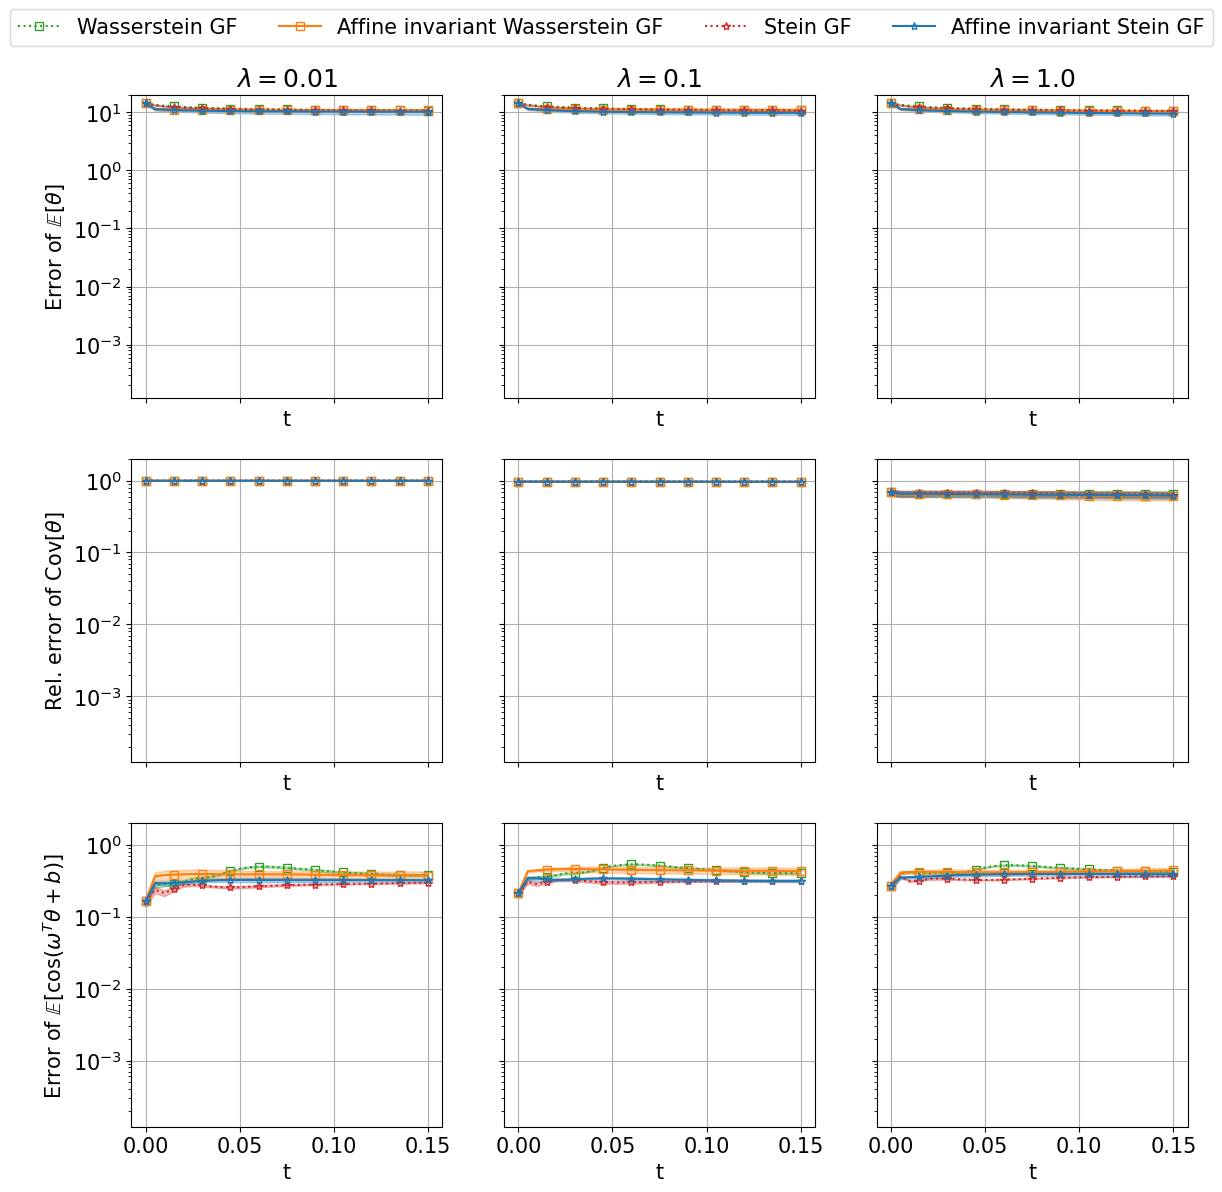

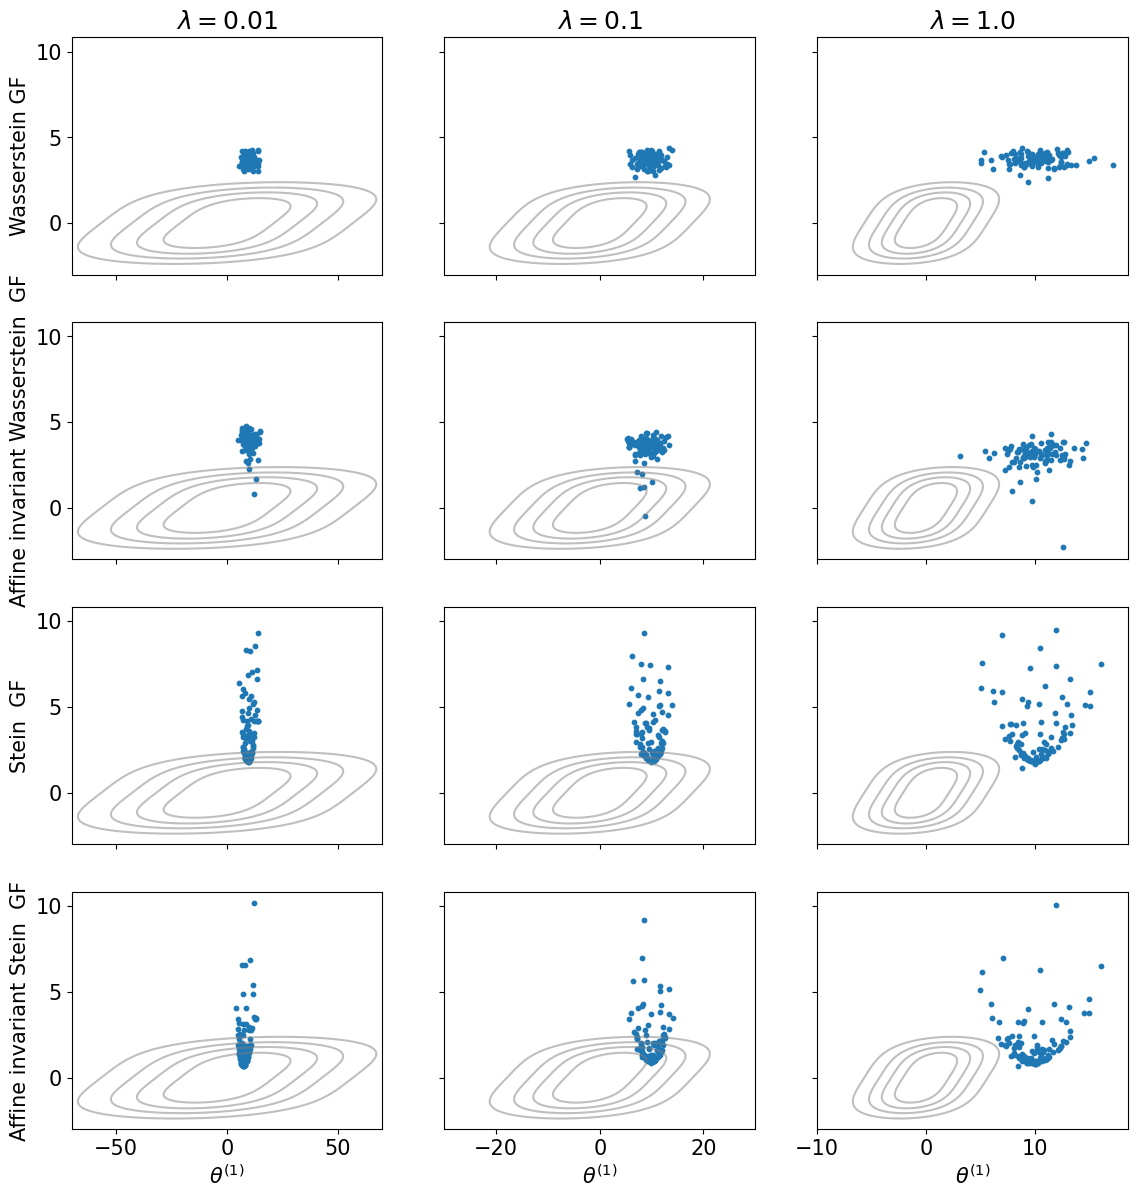

In [ ]:
using Statistics
Random.seed!(42)
######################### TEST #######################################
N_θ = 2
ϵs = [0.01, 0.1, 1] 

s_param = Setup_Param(2, 2)
fig, ax = PyPlot.subplots(ncols=3, nrows=3, sharex=true, sharey="row", figsize=(12,12))
fig_contour, ax_contour = PyPlot.subplots(ncols=3, nrows=4, sharex="col", sharey=true, figsize=(12,12))

N_ens = 100
Δt = 0.005
N_t = 3000
ts = LinRange(0, Δt*N_t, N_t+1)
xx = LinRange(-100, 100, 4000)
yy = LinRange(-10,  10,  400)
ω =  rand(Normal(0, 1), (20, 2))
b = rand(Uniform(0, 2*pi), 20)
x_ranges = [[-70,70],[-30,30],[-10, 10],[-5, 5],[-3, 3]]
N_repeat = 10



for test_id = 1:length(ϵs)
    
    ϵ = ϵs[test_id]
    
    logρ(θ) = log_concave(θ,  ϵs[test_id])
    
    function ∇logρ(s_param::Setup_Param, θ)
        return logρ(θ), ForwardDiff.gradient(logρ, θ)
    end
    
    m_oo, C_oo, cos_ref  = compute_Eref(ϵs[test_id], ω, b)
    
    # Plot reference contour
    x_min, x_max = x_ranges[test_id]
    y_min, y_max = -3, 3
    N_x, N_y = 200, 200
    xx_contour = Array(LinRange(x_min, x_max, N_x))
    yy_contour = Array(LinRange(y_min, y_max, N_y))
    X_contour,Y_contour = repeat(xx_contour, 1, N_y), repeat(yy_contour, 1, N_x)'
    Z_contour = zeros(N_x, N_y)
    for i = 1:N_x
        for j = 1:N_y
            Z_contour[i, j] = logρ( [X_contour[i,j], Y_contour[i,j]] )
        end
    end
    Z_contour .= exp.(Z_contour)
    for i = 1:4
        ax_contour[i, test_id].contour(X_contour, Y_contour, Z_contour, 5, colors="grey", alpha=0.5)
    end
    
    # Particle simulation
    ips_errors = Dict("Wasserstein" => zeros(N_repeat, 2, N_t+1, 3), "Stein" => zeros(N_repeat, 2, N_t+1, 3))
    for id_repeat = 1:N_repeat
        θ0 = Array(rand(MvNormal(m_0, C_0), N_ens)')
        for method in ["Wasserstein", "Stein"]
            for preconditioner in [false, true]
        
                ips_obj = IPS_Run(s_param, ∇logρ, θ0, N_ens, Δt, N_t, method, preconditioner)
    
                for i = 1:N_t+1
                    ips_errors[method][id_repeat, 1 + Int(preconditioner), i, 1] = norm(dropdims(mean(ips_obj.θ[i], dims=1), dims=1) .- m_oo)
                    ips_errors[method][id_repeat, 1 + Int(preconditioner), i, 2] = norm(construct_cov(ips_obj.θ[i]) .- C_oo)/norm(C_oo)
                    ips_errors[method][id_repeat, 1 + Int(preconditioner), i, 3] = norm(cos_ref - cos_error_estimation_particle(ips_obj.θ[i], ω, b ))/sqrt(length(b))
                end
                
                
                                # For the first repeat, visualize in the contour plot
                if id_repeat == 1   
                    if (method == "Wasserstein" && ~preconditioner)
                        ax_contour[1, test_id].scatter(ips_obj.θ[end][:, 1], ips_obj.θ[end][:, 2], s = 10)
                    elseif (method == "Wasserstein" && preconditioner)
                        ax_contour[2, test_id].scatter(ips_obj.θ[end][:, 1], ips_obj.θ[end][:, 2], s = 10)
                    elseif (method == "Stein" && ~preconditioner)
                        ax_contour[3, test_id].scatter(ips_obj.θ[end][:, 1], ips_obj.θ[end][:, 2], s = 10)
                    else 
                        ax_contour[4, test_id].scatter(ips_obj.θ[end][:, 1], ips_obj.θ[end][:, 2], s = 10)
                    end
                end
            end
        end
    end

    ###########  Error plot
    ites = Array(0:N_t)
    markevery = div(N_t, 10)
    for method in ["Wasserstein", "Stein"]
        for preconditioner in [false, true]
            if (method  == "Wasserstein" || method  == "Stein")
                label = (preconditioner ? "Affine invariant "*method : method) * " GF"
                color = (method  == "Stein" ? "C0" : "C1")
                if method  ==  "Wasserstein" && ~preconditioner
                    color  = "C2"
                end
                if method  ==  "Stein" && ~preconditioner
                    color  = "C3"
                end
                
                marker = (method  == "Stein" ? "*" : "s")
            end
            linestyle = preconditioner ?  "solid" : "dotted"
            for id_statistics = 1:3
                mean_f = mean(ips_errors[method][:, 1 + Int(preconditioner), : , id_statistics], dims=1)[:]
                std_f  = std( ips_errors[method][:, 1 + Int(preconditioner), : , id_statistics], dims=1)[:]
            
                ax[id_statistics, test_id].semilogy(ts, mean_f, linestyle=linestyle, color=color, marker=marker, fillstyle="none", label=label, markevery = markevery)
                ax[id_statistics, test_id].fill_between(ts, mean_f .- std_f, mean_f .+ std_f, color=color, alpha=0.3)
                ax[id_statistics, test_id].set_yscale("log")
            end
        end
    end

    ax_contour[1, test_id].set_title(L"\lambda = " * string(ϵ))                   
    ax[1, test_id].set_title(L"\lambda = " * string(ϵ))
    ax[1, test_id].set_xlabel("t")
    ax[2, test_id].set_xlabel("t")
    ax[3, test_id].set_xlabel("t")
        
    ax[1, test_id].set_ylim([1.2e-3,2.0e1])
    ax[2, test_id].set_ylim([1.2e-3,2.0e0])
    ax[3, test_id].set_ylim([1.2e-3,2.0e0])  

        
    ax[1, test_id].grid("on")
    ax[2, test_id].grid("on")
    ax[3, test_id].grid("on")
    
    
    ax_contour[4,test_id].set_xlabel(L"\theta^{(1)}")
    
end

handles, labels = ax[1,1].get_legend_handles_labels()
fig.legend(handles,labels,loc = "upper center",bbox_to_anchor=(0.5,0.99),ncol=5)

ax[1,1].set_ylabel(L"Error of $\mathbb{E}[\theta]$")
ax[2,1].set_ylabel(L"Rel. error of Cov$[\theta]$")
ax[3,1].set_ylabel(L"Error of $\mathbb{E}[\cos(\omega^T\theta + b)]$")
fig.subplots_adjust(bottom=0.05,top=0.91,left=0.1,right=0.98,hspace=0.2)
fig.savefig("Logconcave_gd_particle_converge.pdf")


ax_contour[1, 1].set_ylabel("Wasserstein GF")
ax_contour[2, 1].set_ylabel("Affine invariant Wasserstein  GF")
ax_contour[3, 1].set_ylabel("Stein  GF")
ax_contour[4, 1].set_ylabel("Affine invariant Stein  GF")
fig_contour.subplots_adjust(bottom=0.05,top=0.96,left=0.1,right=0.98,hspace=0.2)
fig_contour.savefig("Logconcave_gd_particle_contour.pdf")
